In this notebook, I train a transformer model on the news-commentary-v16 dataset. The main purpose of this notebook is to study how the performance of the model changes as training set size increases. The result is shown in the plots at the end of this notebook.

In [23]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/My\ Drive/ML/Transformers
# !ls

In [24]:
# 1. 创建目标文件夹
!mkdir -p data

# 2. 使用 wget 下载文件到 data 文件夹
# 假设文件名为 news-commentary-v16.en-zh.tsv，您需要根据实际的文件名和链接进行调整
# 请注意，根据 statmt 网站的惯例，可能需要下载压缩包（如 .tgz）并解压
# 示例下载一个常见的平行语料库文件（请根据您实际需要的文件名修改）
!wget -P data/ https://data.statmt.org/news-commentary/v16/training/news-commentary-v16.en-zh.tsv.gz

# 3. 解压文件（如果下载的是 .gz 压缩包）
!gunzip data/news-commentary-v16.en-zh.tsv.gz
# 确保解压后的文件名与您的代码一致： 'data/news-commentary-v16.en-zh.tsv'

--2025-11-30 19:43:50--  https://data.statmt.org/news-commentary/v16/training/news-commentary-v16.en-zh.tsv.gz
Resolving data.statmt.org (data.statmt.org)... 129.215.32.28
Connecting to data.statmt.org (data.statmt.org)|129.215.32.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36938999 (35M) [application/x-gzip]
Saving to: ‘data/news-commentary-v16.en-zh.tsv.gz’

news-commentary-v16 100%[===================>]  35.23M  6.53MB/s    in 5.4s    

2025-11-30 19:43:56 (6.53 MB/s) - ‘data/news-commentary-v16.en-zh.tsv.gz’ saved [36938999/36938999]



In [25]:
!pip install sentencepiece --quiet
!pip install sacrebleu --quiet
!pip install torchinfo

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [26]:
import math
from dataclasses import dataclass

import numpy as np
import sacrebleu
import sentencepiece as spm
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from tqdm import tqdm
import pandas
torch.manual_seed(0)
import random
random.seed(0)
import  pathlib
import json
import matplotlib.pyplot as plt
from torchinfo import summary

# 1. 检查是否有足够的设备
if torch.cuda.device_count() > 2:
    DEVICE = torch.device("cuda:2") # 明确指定使用 cuda:2
else:
    # 如果没有 cuda:2，则使用 cuda:0 或 CPU 作为备用
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(DEVICE)

cuda:2


In [27]:
SRC = "zh"
TRG = "en"
en_vocab_size = 30000
zh_vocab_size = 30000
vocab_sizes = {"en": en_vocab_size, "zh": zh_vocab_size}
max_seq_len = 50

# Get English and Chinese tokenizers

I use [SentencePiece](https://github.com/google/sentencepiece) to get both the Chinese and English tokenizers.

The news-commentary-v16 dataset can be downloaded from https://data.statmt.org/news-commentary/v16/training/.

The validation set and test set I used are simply sampled from the news-commentary-v16 dataset, both with a size of 5000.


In [28]:
full_set = pandas.read_csv('data/news-commentary-v16.en-zh.tsv',
                           sep='\t', header=None)
full_set = [(full_set[0][i], full_set[1][i]) for i in range(len(full_set[0]))
          if not isinstance(full_set[0][i], float) and not isinstance(full_set[1][i], float)]
random.shuffle(full_set)
# Note that some translations are really bad, and somehow news-commentary-v16 seems to
# be one of the popular (small) training set...
full_train_set, valid_set, test_set= torch.utils.data.random_split(
                                        full_set, [len(full_set)-10000, 5000, 5000],
                                        generator=torch.Generator().manual_seed(42))
print(len(full_train_set), len(valid_set), len(test_set))
for i in range(3):
    print(full_train_set[i])

303674 5000 5000
('Unfortunately, the outcome could be similar: the entire banking system sent into a tailspin.', '不幸的是结果可能重蹈覆辙： 整个银行系统可能因此陷入一片狼藉。')
('First, “genetic engineering cannot solve the hunger and food insecurity problem.”', '想一想汽车的发明就造成了多少轮下冤魂，更不用说各种药物的副作用了。')
('Indeed, the time is ripe to offer assurances to the isolated Syrian regime that blocking Hezbollah’s rearmament, stopping Islamist fighters’ passage into Iraq, and improving the country’s appalling human rights record would bring valuable diplomatic and economic benefits, including a strengthened association agreement with the EU.', '的确，给备受孤立的叙利亚政权一些安慰的时机已经成熟。 要让其明白封锁真主党的军备，阻止伊斯兰好战分子进入伊拉克并改善自身触目惊心的人权记录会给它带来外交和经济上的实惠，其中包括强化与欧盟的联合协定。')


In [29]:
def get_tokenizers(dataset, train_set_size):
    en_file = f'data/zh-en_corpus_en_trainsize_{train_set_size}.txt'
    zh_file = f'data/zh-en_corpus_zh_trainsize_{train_set_size}.txt'
    en_sp_model = f'zh-en_en_trainsize_{train_set_size}'
    zh_sp_model = f'zh-en_zh_trainsize_{train_set_size}'
    f_en = open(en_file, "w")
    f_zh = open(zh_file, "w")
    for pair in list(dataset)[0:train_set_size]:
        f_en.write(pair[0] + '\n')
        f_zh.write(pair[1] + '\n')
    f_en.close()
    f_zh.close()
    # train sentencepiece models to get tokenizers
    spm.SentencePieceTrainer.train\
        (f'--input={en_file} --model_prefix=en_sp_model  --user_defined_symbols=<pad> --vocab_size={en_vocab_size}')
    spm.SentencePieceTrainer.train\
        (f'--input={zh_file} --model_prefix=zh_sp_model --user_defined_symbols=<pad> --vocab_size={zh_vocab_size}')

    # make SentencePieceProcessor instances and load the model files
    en_sp = spm.SentencePieceProcessor()
    en_sp.load(f'en_sp_model.model')
    zh_sp = spm.SentencePieceProcessor()
    zh_sp.load(f'zh_sp_model.model')

    tokenizers = {"en": en_sp.encode_as_ids, "zh": zh_sp.encode_as_ids}
    detokenizers = {"en":en_sp.decode_ids, "zh":zh_sp.decode_ids}
    id_to_pieces = {"en":en_sp.id_to_piece, "zh":zh_sp.id_to_piece}
    return tokenizers, detokenizers, id_to_pieces

In [30]:
tokenizers, detokenizers, id_to_pieces = get_tokenizers(full_train_set, 50000)
print(tokenizers['zh']('这是一个测试。'))
print(tokenizers['en']('This is a test.'))
print([id_to_pieces['zh'](id) for id in range(20)])
print([id_to_pieces['en'](id) for id in range(20)])

[4347, 2043, 5]
[90, 14, 10, 1551, 6]
['<unk>', '<s>', '</s>', '<pad>', ',', '。', '▁', '的', '▁—', '和', '、', '在', '(', '是', '“', ')', '了', '对', '年', '而']
['<unk>', '<s>', '</s>', '<pad>', ',', '▁the', '.', '▁to', '▁of', '▁and', '▁a', '▁in', 's', '▁that', '▁is', '-', '’', '▁', '▁for', '▁–']


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=data/zh-en_corpus_en_trainsize_50000.txt --model_prefix=en_sp_model  --user_defined_symbols=<pad> --vocab_size=30000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/zh-en_corpus_en_trainsize_50000.txt
  input_format: 
  model_prefix: en_sp_model
  model_type: UNIGRAM
  vocab_size: 30000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <pad>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_

In [31]:
# indexes of special symbols
UNK, BOS, EOS, PAD = 0, 1, 2, 3

# Data processing

In [32]:
def tokenize_dataset(dataset):
    'tokenize a dataset and add [BOS] and [EOS] to the beginning and end of the sentences'
    if SRC == "zh":
        return [(torch.tensor([BOS]+tokenizers[SRC](src_text)[0:max_seq_len-2]+[EOS]),
                 torch.tensor([BOS]+tokenizers[TRG](trg_text)[0:max_seq_len-2]+[EOS]))
                 for trg_text, src_text in dataset]
    else:
        return [(torch.tensor([BOS]+tokenizers[SRC](src_text)[0:max_seq_len-2]+[EOS]),
                 torch.tensor([BOS]+tokenizers[TRG](trg_text)[0:max_seq_len-2]+[EOS]))
                 for src_text, trg_text in dataset]


In [33]:
class TranslationDataset(Dataset):
    'create a dataset for torch.utils.data.DataLoader() '
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def pad_sequence(batch):
    'collate function for padding sentences such that all the sentences in the batch have the same length'
    src_seqs  = [src for src, trg in batch]
    trg_seqs  = [trg for src, trg in batch]
    src_padded = torch.nn.utils.rnn.pad_sequence(src_seqs,
                                batch_first=True, padding_value = PAD)
    trg_padded = torch.nn.utils.rnn.pad_sequence(trg_seqs,
                                batch_first=True, padding_value = PAD)
    return src_padded, trg_padded


In [34]:
batch_size = 128

class Dataloaders:
    'Dataloaders contains train_loader, test_loader and valid_loader for training and evaluation '
    def __init__(self, train_set_size):
        train_set = list(full_train_set)[0:train_set_size]
        train_dataset = TranslationDataset(tokenize_dataset(train_set))
        valid_dataset = TranslationDataset(tokenize_dataset(valid_set))
        test_dataset  = TranslationDataset(tokenize_dataset(test_set))

        # each batch returned by dataloader will be padded such that all the texts in
        # that batch have the same length as the longest text in that batch
        self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn = pad_sequence)

        self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn=pad_sequence)

        self.valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn=pad_sequence)


# Transformer Model


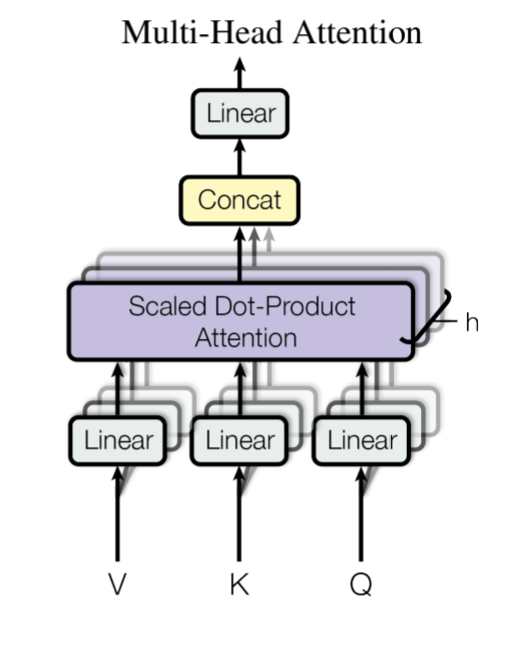

In [35]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_embed, dropout=0.0):
        super(MultiHeadedAttention, self).__init__()
        assert d_embed % h == 0 # check the h number
        self.d_k = d_embed//h
        self.d_embed = d_embed
        self.h = h
        self.WQ = nn.Linear(d_embed, d_embed)
        self.WK = nn.Linear(d_embed, d_embed)
        self.WV = nn.Linear(d_embed, d_embed)
        self.linear = nn.Linear(d_embed, d_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_query, x_key, x_value, mask=None):
        nbatch = x_query.size(0) # get batch size
        # 1) Linear projections to get the multi-head query, key and value tensors
        # x_query, x_key, x_value dimension: nbatch * seq_len * d_embed
        # LHS query, key, value dimensions: nbatch * h * seq_len * d_k
        query = self.WQ(x_query).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        key   = self.WK(x_key).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        value = self.WV(x_value).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        # 2) Attention
        # scores has dimensions: nbatch * h * seq_len * seq_len
        scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(self.d_k)
        # 3) Mask out padding tokens and future tokens
        if mask is not None:
            scores = scores.masked_fill(mask, float('-inf'))
        # p_atten dimensions: nbatch * h * seq_len * seq_len
        p_atten = torch.nn.functional.softmax(scores, dim=-1)
        p_atten = self.dropout(p_atten)
        # x dimensions: nbatch * h * seq_len * d_k
        x = torch.matmul(p_atten, value)
        # x now has dimensions:nbtach * seq_len * d_embed
        x = x.transpose(1, 2).contiguous().view(nbatch, -1, self.d_embed)
        return self.linear(x) # final linear layer


class ResidualConnection(nn.Module):
  '''residual connection: x + dropout(sublayer(layernorm(x))) '''
  def __init__(self, dim, dropout):
      super().__init__()
      self.drop = nn.Dropout(dropout)
      self.norm = nn.LayerNorm(dim)

  def forward(self, x, sublayer):
      return x + self.drop(sublayer(self.norm(x)))

# I simply let the model learn the positional embeddings in this notebook, since this
# almost produces identital results as using sin/cosin functions embeddings, as claimed
# in the original transformer paper. Note also that in the original paper, they multiplied
# the token embeddings by a factor of sqrt(d_embed), which I do not do here.

class Encoder(nn.Module):
    '''Encoder = token embedding + positional embedding -> a stack of N EncoderBlock -> layer norm'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.encoder_vocab_size, config.d_embed)
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed))
        self.encoder_blocks = nn.ModuleList([EncoderBlock(config) for _ in range(config.N_encoder)])
        self.dropout = nn.Dropout(config.dropout)
        self.norm = nn.LayerNorm(config.d_embed)

    def forward(self, input, mask=None):
        x = self.tok_embed(input)
        x_pos = self.pos_embed[:, :x.size(1), :]
        x = self.dropout(x + x_pos)
        for layer in self.encoder_blocks:
            x = layer(x, mask)
        return self.norm(x)


class EncoderBlock(nn.Module):
    '''EncoderBlock: self-attention -> position-wise fully connected feed-forward layer'''
    def __init__(self, config):
        super(EncoderBlock, self).__init__()
        self.atten = MultiHeadedAttention(config.h, config.d_embed, config.dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residual1 = ResidualConnection(config.d_embed, config.dropout)
        self.residual2 = ResidualConnection(config.d_embed, config.dropout)

    def forward(self, x, mask=None):
        # self-attention
        x = self.residual1(x, lambda x: self.atten(x, x, x, mask=mask))
        # position-wise fully connected feed-forward layer
        return self.residual2(x, self.feed_forward)


class Decoder(nn.Module):
    '''Decoder = token embedding + positional embedding -> a stack of N DecoderBlock -> fully-connected layer'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.decoder_vocab_size, config.d_embed)
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed))
        self.dropout = nn.Dropout(config.dropout)
        self.decoder_blocks = nn.ModuleList([DecoderBlock(config) for _ in range(config.N_decoder)])
        self.norm = nn.LayerNorm(config.d_embed)
        self.linear = nn.Linear(config.d_embed, config.decoder_vocab_size)

    def future_mask(self, seq_len):
        '''mask out tokens at future positions'''
        mask = (torch.triu(torch.ones(seq_len, seq_len, requires_grad=False), diagonal=1)!=0).to(DEVICE)
        return mask.view(1, 1, seq_len, seq_len)

    def forward(self, memory, src_mask, trg, trg_pad_mask):
        seq_len = trg.size(1)
        trg_mask = torch.logical_or(trg_pad_mask, self.future_mask(seq_len))
        x = self.tok_embed(trg) + self.pos_embed[:, :trg.size(1), :]
        x = self.dropout(x)
        for layer in self.decoder_blocks:
            x = layer(memory, src_mask, x, trg_mask)
        x = self.norm(x)
        logits = self.linear(x)
        return logits


class DecoderBlock(nn.Module):
    ''' EncoderBlock: self-attention -> position-wise feed-forward (fully connected) layer'''
    def __init__(self, config):
        super().__init__()
        self.atten1 = MultiHeadedAttention(config.h, config.d_embed)
        self.atten2 = MultiHeadedAttention(config.h, config.d_embed)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residuals = nn.ModuleList([ResidualConnection(config.d_embed, config.dropout)
                                       for i in range(3)])

    def forward(self, memory, src_mask, decoder_layer_input, trg_mask):
        x = memory
        y = decoder_layer_input
        y = self.residuals[0](y, lambda y: self.atten1(y, y, y, mask=trg_mask))
        # keys and values are from the encoder output
        y = self.residuals[1](y, lambda y: self.atten2(y, x, x, mask=src_mask))
        return self.residuals[2](y, self.feed_forward)


class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_mask, trg, trg_pad_mask):
        return self.decoder(self.encoder(src, src_mask), src_mask, trg, trg_pad_mask)

In [36]:
@dataclass
class ModelConfig:
    encoder_vocab_size: int
    decoder_vocab_size: int
    d_embed: int
    # d_ff is the dimension of the fully-connected  feed-forward layer
    d_ff: int
    # h is the number of attention head
    h: int
    N_encoder: int
    N_decoder: int
    max_seq_len: int
    dropout: float

def make_model(config):
    model = Transformer(Encoder(config), Decoder(config)).to(DEVICE)

    # initialize model parameters
    # it seems that this initialization is very important!
    for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    return model

# Training and evaluation helper functions

In [37]:
def make_batch_input(x, y):
        src = x.to(DEVICE)
        trg_in = y[:, :-1].to(DEVICE)
        trg_out = y[:, 1:].contiguous().view(-1).to(DEVICE)
        src_pad_mask = (src == PAD).view(src.size(0), 1, 1, src.size(-1))
        trg_pad_mask = (trg_in == PAD).view(trg_in.size(0), 1, 1, trg_in.size(-1))
        return src, trg_in, trg_out, src_pad_mask, trg_pad_mask

In [38]:
def train_epoch(model, dataloaders):
    model.train()
    grad_norm_clip = 1.0
    losses, acc, count = [], 0, 0
    num_batches = len(dataloaders.train_loader)
    pbar = tqdm(enumerate(dataloaders.train_loader), total=num_batches)
    for idx, (x, y)  in  pbar:
        optimizer.zero_grad()
        src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
        pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
        pred = pred.view(-1, pred.size(-1))
        loss = loss_fn(pred, trg_out).to(DEVICE)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
        # report progress
        if idx>0 and idx%50 == 0:
            pbar.set_description(f'train loss={loss.item():.3f}, lr={scheduler.get_last_lr()[0]:.5f}')
    return np.mean(losses)


def train(model, dataloaders, epochs = 10):
    global early_stop_count
    best_valid_loss = float('inf')
    train_size = len(dataloaders.train_loader)*batch_size
    for ep in range(epochs):
        train_loss = train_epoch(model, dataloaders)
        valid_loss = validate(model, dataloaders.valid_loader)

        print(f'ep: {ep}: train_loss={train_loss:.5f}, valid_loss={valid_loss:.5f}')
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
        else:
            if scheduler.last_epoch>1.5*warmup_steps:
                early_stop_count -= 1
                if early_stop_count<=0:
                    return train_loss, valid_loss
    return train_loss, valid_loss


def validate(model, dataloder):
    'compute the validation loss'
    model.eval()
    losses = []
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloder):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
            pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
            pred = pred.view(-1, pred.size(-1))
            losses.append(loss_fn(pred, trg_out).item())
    return np.mean(losses)

In [39]:
def translate(model, x):
    'translate source sentences into the target language, without looking at the answer'
    with torch.no_grad():
        dB = x.size(0)
        y = torch.tensor([[BOS]*dB]).view(dB, 1).to(DEVICE)
        x_pad_mask = (x == PAD).view(x.size(0), 1, 1, x.size(-1)).to(DEVICE)
        memory = model.encoder(x, x_pad_mask)
        for i in range(max_seq_len):
            y_pad_mask = (y == PAD).view(y.size(0), 1, 1, y.size(-1)).to(DEVICE)
            logits = model.decoder(memory, x_pad_mask, y, y_pad_mask)
            last_output = logits.argmax(-1)[:, -1]
            last_output = last_output.view(dB, 1)
            y = torch.cat((y, last_output), 1).to(DEVICE)
    return y

In [40]:
def remove_pad(sent):
    '''truncate the sentence if BOS is in it,
     otherwise simply remove the padding tokens at the end'''
    if sent.count(EOS)>0:
      sent = sent[0:sent.index(EOS)+1]
    while sent and sent[-1] == PAD:
            sent = sent[:-1]
    return sent

def decode_sentence(detokenizer, sentence_ids):
    'convert a tokenized sentence (a list of numbers) to a literal string'
    if not isinstance(sentence_ids, list):
        sentence_ids = sentence_ids.tolist()
    sentence_ids = remove_pad(sentence_ids)
    return detokenizer(sentence_ids).replace("<bos>", "")\
           .replace("<eos>", "").strip().replace(" .", ".")

def evaluate(model, dataloader, num_batch=None):
    'evaluate the model, and compute the BLEU score'
    model.eval()
    refs, cans, bleus = [], [], []
    with torch.no_grad():
        for idx, (x, y) in enumerate(dataloader):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
            translation = translate(model, src)
            trg_out = trg_out.view(x.size(0), -1)
            refs = refs + [decode_sentence(detokenizers[TRG], trg_out[i]) for i in range(len(src))]
            cans = cans + [decode_sentence(detokenizers[TRG], translation[i]) for i in range(len(src))]
            if num_batch and idx>=num_batch:
                break
        bleus.append(sacrebleu.corpus_bleu(cans, [refs]).score)
        # print some examples
        for i in range(3):
            print(f'src:  {decode_sentence(detokenizers[SRC], src[i])}')
            print(f'trg:  {decode_sentence(detokenizers[TRG], trg_out[i])}')
            print(f'pred: {decode_sentence(detokenizers[TRG], translation[i])}')
        return np.mean(bleus)

# Training

In [41]:
import os
# ... 在 for 循环开始前加入
OUTPUT_DIR = 'saved_models_news-commentary-v16_only'
os.makedirs(OUTPUT_DIR, exist_ok=True)

config = ModelConfig(encoder_vocab_size = vocab_sizes[SRC],
                     decoder_vocab_size=vocab_sizes[TRG],
                     d_embed=512,
                     d_ff=2048,
                     h=8,
                     N_encoder=6,
                     N_decoder=6,
                     max_seq_len=max_seq_len,
                     dropout=0.1
                     )
results = {}
for train_size in  np.array([5, 10, 15, 20, 25, 30])*10000:
    tokenizers, detokenizers, id_to_pieces = get_tokenizers(full_train_set, train_size)
    data_loaders = Dataloaders(train_size)
    model = make_model(config)
    model_size = sum([p.numel() for p in model.parameters()])
    print(f'model_size: {model_size}, train_set_size: {train_size}')
    warmup_steps = 4*len(data_loaders.train_loader)
    # lr first increases in the warmup steps, and then descreases
    lr_fn = lambda step: config.d_embed**(-0.5) * min([(step+1)**(-0.5), (step+1)*warmup_steps**(-1.5)])
    optimizer = torch.optim.Adam(model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_fn)
    loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)
    early_stop_count = 2
    train_loss, valid_loss = train(model, data_loaders, epochs=30)
    test_loss  = validate(model, data_loaders.test_loader)

    print("train set examples:")
    train_bleu = evaluate(model, data_loaders.train_loader, 20)
    print("validation set examples:")
    valid_bleu = evaluate(model, data_loaders.valid_loader)
    print("test set examples:")
    test_bleu  = evaluate(model, data_loaders.test_loader)
    results[f'model_size={model_size}, train_size={train_size}'] = {
                                        'train_loss': train_loss,
                                        'valid_loss': valid_loss,
                                        'test_loss' : test_loss,
                                        'train_bleu': train_bleu,
                                        'valid_bleu': valid_bleu,
                                        'test_bleu': test_bleu}
    f = open('results_news-commentary-v16_only.json', 'w')
    json.dump(results, f)
    f.close()
    torch.save(model, f'saved_models_news-commentary-v16_only/{SRC}_to_{TRG}_dataset_size_{train_size}_model_size_{model_size}.pt')
    print(f'train_loss: {train_loss:.4f}, valid_loss: {valid_loss:.4f}, test_loss: {test_loss:.4f}')
    print(f'test_bleu: {test_bleu:.4f}, valid_bleu: {valid_bleu:.4f} train_bleu: {train_bleu:.4f}')

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=data/zh-en_corpus_en_trainsize_50000.txt --model_prefix=en_sp_model  --user_defined_symbols=<pad> --vocab_size=30000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/zh-en_corpus_en_trainsize_50000.txt
  input_format: 
  model_prefix: en_sp_model
  model_type: UNIGRAM
  vocab_size: 30000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <pad>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_

model_size: 90301744, train_set_size: 50000


train loss=5.798, lr=0.00025: 100%|██████████| 391/391 [00:39<00:00,  9.80it/s]


ep: 0: train_loss=7.15581, valid_loss=5.71000


train loss=4.922, lr=0.00053: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]


ep: 1: train_loss=5.26921, valid_loss=4.96527


train loss=4.574, lr=0.00081: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]


ep: 2: train_loss=4.59741, valid_loss=4.53966


train loss=4.192, lr=0.00109: 100%|██████████| 391/391 [00:40<00:00,  9.69it/s]


ep: 3: train_loss=4.11665, valid_loss=4.29641


train loss=3.715, lr=0.00101: 100%|██████████| 391/391 [00:40<00:00,  9.70it/s]


ep: 4: train_loss=3.69374, valid_loss=4.02986


train loss=3.406, lr=0.00092: 100%|██████████| 391/391 [00:40<00:00,  9.71it/s]


ep: 5: train_loss=3.23729, valid_loss=3.88020


train loss=2.819, lr=0.00085: 100%|██████████| 391/391 [00:40<00:00,  9.70it/s]


ep: 6: train_loss=2.82932, valid_loss=3.77535


train loss=2.591, lr=0.00080: 100%|██████████| 391/391 [00:40<00:00,  9.69it/s]


ep: 7: train_loss=2.45905, valid_loss=3.75833


train loss=2.190, lr=0.00075: 100%|██████████| 391/391 [00:40<00:00,  9.70it/s]


ep: 8: train_loss=2.12863, valid_loss=3.79491


train loss=1.908, lr=0.00071: 100%|██████████| 391/391 [00:40<00:00,  9.68it/s]


ep: 9: train_loss=1.83850, valid_loss=3.85469
train set examples:
src:  为改革进程融资 — — 更不要说筹集高达2万亿规模的公共投资资金以支持后石油时期经济 — — 将需要提高工作效率、实现快速私有化、建立有效的公私伙伴关系、采纳基础广泛的税收制度(包括将于2018年开始实行
trg:  Financing the reforms – not to mention a massive $2 trillion public investment fund to support a post-oil economy – will require improved efficiency, rapid privatization, effective public-private partnerships, broad-based taxation (including a value-added tax
pred: Financing funding – not to mention the massive flow of public investment in the economy – will require an effective time to support effective tax opportunities and capitalize on the rapid development of public-private partnerships – to create effective, broad, broad, broad
src:  在职业女性这一方面,日本就好像是发达国家中的沙特阿拉伯。
trg:  For women in the workplace, Japan remains the Saudi Arabia of the developed world.
pred: In professional women, Japan like the Arabian Peninsula is Saudi Arabia.
src:  这相当于亲西方势力在中东地区获胜。
trg:  This would amount to a win for pro-Western for

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=data/zh-en_corpus_en_trainsize_100000.txt --model_prefix=en_sp_model  --user_defined_symbols=<pad> --vocab_size=30000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/zh-en_corpus_en_trainsize_100000.txt
  input_format: 
  model_prefix: en_sp_model
  model_type: UNIGRAM
  vocab_size: 30000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <pad>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  see

model_size: 90301744, train_set_size: 100000


train loss=5.554, lr=0.00019: 100%|██████████| 782/782 [01:20<00:00,  9.77it/s]


ep: 0: train_loss=6.85522, valid_loss=5.44740


train loss=4.675, lr=0.00039: 100%|██████████| 782/782 [01:20<00:00,  9.66it/s]


ep: 1: train_loss=4.96635, valid_loss=4.49922


train loss=3.889, lr=0.00059: 100%|██████████| 782/782 [01:21<00:00,  9.64it/s]


ep: 2: train_loss=4.09568, valid_loss=3.81928


train loss=3.279, lr=0.00078: 100%|██████████| 782/782 [01:20<00:00,  9.68it/s]


ep: 3: train_loss=3.45453, valid_loss=3.39471


train loss=2.808, lr=0.00071: 100%|██████████| 782/782 [01:20<00:00,  9.68it/s]


ep: 4: train_loss=2.97063, valid_loss=3.04181


train loss=2.559, lr=0.00065: 100%|██████████| 782/782 [01:20<00:00,  9.75it/s]


ep: 5: train_loss=2.55122, valid_loss=2.85182


train loss=2.204, lr=0.00060: 100%|██████████| 782/782 [01:20<00:00,  9.74it/s]


ep: 6: train_loss=2.23462, valid_loss=2.75221


train loss=2.047, lr=0.00056: 100%|██████████| 782/782 [01:21<00:00,  9.64it/s]


ep: 7: train_loss=1.98032, valid_loss=2.72975


train loss=1.861, lr=0.00053: 100%|██████████| 782/782 [01:20<00:00,  9.66it/s]


ep: 8: train_loss=1.76386, valid_loss=2.73592


train loss=1.679, lr=0.00050: 100%|██████████| 782/782 [01:21<00:00,  9.65it/s]


ep: 9: train_loss=1.57710, valid_loss=2.74589
train set examples:
src:  它可能是一个例外,反映了各种因素,包括欧元危机、欧洲国家经济持续萎靡、大宗商品价格暴跌、巴西、俄罗斯和其他新兴经济体大幅放缓、国际银行监管收紧(可能拖累贸易融资)等。
trg:  It may have been a singular occurrence that reflected a variety of factors, including the euro crisis; continued economic weakness in many European countries; the sharp decline in commodity prices; dramatic slowdowns in Brazil, Russia, and other emerging economies; and
pred: It may be a singular occurrence that reflects factors that involve a euro crisis, the European Union’s continued economic malaise, a sharp decline in commodity prices, a sharp slowdown in the Brazil, Russia, and other emerging economies, the international banking
src:  中等收入的非经合组织国家 — — 尤其是中国和印度 — — 正逐渐成为高技术劳动力越来越重要的目标国。
trg:  Middle-income non-OECD countries – particularly China and India – are becoming an increasingly important destination for high-skilled labor.
pred: The non-income OECD countries – especially China and India – are increasingly important

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=data/zh-en_corpus_en_trainsize_150000.txt --model_prefix=en_sp_model  --user_defined_symbols=<pad> --vocab_size=30000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/zh-en_corpus_en_trainsize_150000.txt
  input_format: 
  model_prefix: en_sp_model
  model_type: UNIGRAM
  vocab_size: 30000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <pad>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  see

model_size: 90301744, train_set_size: 150000


train loss=5.383, lr=0.00016: 100%|██████████| 1172/1172 [02:00<00:00,  9.71it/s]


ep: 0: train_loss=6.71571, valid_loss=5.31700


train loss=4.342, lr=0.00032: 100%|██████████| 1172/1172 [02:00<00:00,  9.75it/s]


ep: 1: train_loss=4.75643, valid_loss=4.18448


train loss=3.431, lr=0.00048: 100%|██████████| 1172/1172 [02:01<00:00,  9.63it/s]


ep: 2: train_loss=3.74924, valid_loss=3.38251


train loss=3.050, lr=0.00064: 100%|██████████| 1172/1172 [02:01<00:00,  9.67it/s]


ep: 3: train_loss=3.08043, valid_loss=2.95564


train loss=2.710, lr=0.00058: 100%|██████████| 1172/1172 [02:01<00:00,  9.64it/s]


ep: 4: train_loss=2.65250, valid_loss=2.63916


train loss=2.281, lr=0.00053: 100%|██████████| 1172/1172 [02:01<00:00,  9.65it/s]


ep: 5: train_loss=2.30365, valid_loss=2.49817


train loss=2.052, lr=0.00049: 100%|██████████| 1172/1172 [02:00<00:00,  9.71it/s]


ep: 6: train_loss=2.05148, valid_loss=2.44065


train loss=1.979, lr=0.00046: 100%|██████████| 1172/1172 [02:00<00:00,  9.69it/s]


ep: 7: train_loss=1.85153, valid_loss=2.36284


train loss=1.898, lr=0.00043: 100%|██████████| 1172/1172 [02:01<00:00,  9.67it/s]


ep: 8: train_loss=1.68446, valid_loss=2.36612


train loss=1.524, lr=0.00041: 100%|██████████| 1172/1172 [02:00<00:00,  9.71it/s]


ep: 9: train_loss=1.54082, valid_loss=2.38421
train set examples:
src:  这种约定俗成的责任意识就可以解释为什么哈米德·卡尔扎伊总统的那么多亲信依然在位,也可以解释塔利班领导人为什么仍然安全。
trg:  This sense of customary obligation is why so many of President Hamid Karzai’s cronies remain in place and Taliban leaders remain safe.
pred: The sense of this sort of mission can be explained by why so many of President Hamid Karzai’s cronies are in place, and why Taliban leaders remain safe.
src:  如果政客们热衷于互相指责的话,就更加难上加难了。
trg:  It becomes harder still when politicians are actively playing the blame game.
pred: It is even harder to blame if politicians are keen to blame each other.
src:  而这个情况之所以没有在希腊身上发生就是因为希腊被单一货币捆住了手脚。
trg:  It hasn’t happened in Greece only because Greece is trapped in the single currency.
pred: This is not the case in Greece, because Greece is being dragged into the single currency.
validation set examples:
src:  无论如何,巴勒斯坦人中间的分歧绝非此次谈判失败的原因。
trg:  Regardless, the division among Palestinians cannot be blamed for the talks’ failure

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=data/zh-en_corpus_en_trainsize_200000.txt --model_prefix=en_sp_model  --user_defined_symbols=<pad> --vocab_size=30000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/zh-en_corpus_en_trainsize_200000.txt
  input_format: 
  model_prefix: en_sp_model
  model_type: UNIGRAM
  vocab_size: 30000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <pad>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  see

model_size: 90301744, train_set_size: 200000


train loss=5.114, lr=0.00014: 100%|██████████| 1563/1563 [02:40<00:00,  9.72it/s]


ep: 0: train_loss=6.60155, valid_loss=5.19914


train loss=3.971, lr=0.00028: 100%|██████████| 1563/1563 [02:40<00:00,  9.72it/s]


ep: 1: train_loss=4.56332, valid_loss=3.88823


train loss=3.197, lr=0.00042: 100%|██████████| 1563/1563 [02:40<00:00,  9.73it/s]


ep: 2: train_loss=3.44764, valid_loss=3.05826


train loss=2.935, lr=0.00056: 100%|██████████| 1563/1563 [02:40<00:00,  9.71it/s]


ep: 3: train_loss=2.82999, valid_loss=2.71211


train loss=2.393, lr=0.00050: 100%|██████████| 1563/1563 [02:41<00:00,  9.66it/s]


ep: 4: train_loss=2.46910, valid_loss=2.44370


train loss=2.172, lr=0.00046: 100%|██████████| 1563/1563 [02:41<00:00,  9.71it/s]


ep: 5: train_loss=2.17255, valid_loss=2.32544


train loss=2.131, lr=0.00042: 100%|██████████| 1563/1563 [02:41<00:00,  9.67it/s]


ep: 6: train_loss=1.96012, valid_loss=2.24881


train loss=1.948, lr=0.00040: 100%|██████████| 1563/1563 [02:41<00:00,  9.67it/s]


ep: 7: train_loss=1.79263, valid_loss=2.22991


train loss=1.701, lr=0.00037: 100%|██████████| 1563/1563 [02:40<00:00,  9.73it/s]


ep: 8: train_loss=1.65487, valid_loss=2.20327


train loss=1.617, lr=0.00035: 100%|██████████| 1563/1563 [02:41<00:00,  9.71it/s]


ep: 9: train_loss=1.53468, valid_loss=2.20483


train loss=1.498, lr=0.00034: 100%|██████████| 1563/1563 [02:41<00:00,  9.67it/s]


ep: 10: train_loss=1.42973, valid_loss=2.24736
train set examples:
src:  一方面,美国财政部不时轻率地给中国贴上“操纵货币”的标签,另一方面,默许石油出口国家同样的策略,美国财政部怎么能这样做呢?
trg:  How can the US Treasury, on the one hand, periodically flirt with labeling China a “currency manipulator” and, on the other hand, condone a similar strategy in oil-exporting countries?
pred: How can the US Treasury, on one hand, be expected to label China “manipulating the currency,” and instead to acquiesce on the same strategy for oil-exporting countries?
src:  如果美国因为关于国家身份的文化战争升级而撕裂,那么特朗普拥有不可思议的将分裂双方最糟糕的特点人格化的能力:持枪 ⁇ 客的目无法纪和城市骗子的强取豪夺。
trg:  If the US is riven by an escalating culture war over its national identity, Trump has the uncanny ability of personifying the worst aspects of both sides of the divide: the lawlessness of the gunslinger and the rapaciousness of the city
pred: If the US is torn apart by the escalating cultural warfare on national identities, Trump has the ability to distinguish the worst traits on both sides: the ability to c

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=data/zh-en_corpus_en_trainsize_250000.txt --model_prefix=en_sp_model  --user_defined_symbols=<pad> --vocab_size=30000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/zh-en_corpus_en_trainsize_250000.txt
  input_format: 
  model_prefix: en_sp_model
  model_type: UNIGRAM
  vocab_size: 30000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <pad>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  see

model_size: 90301744, train_set_size: 250000


train loss=5.120, lr=0.00012: 100%|██████████| 1954/1954 [03:20<00:00,  9.74it/s]


ep: 0: train_loss=6.53422, valid_loss=5.13529


train loss=3.671, lr=0.00025: 100%|██████████| 1954/1954 [03:23<00:00,  9.61it/s]


ep: 1: train_loss=4.43554, valid_loss=3.72563


train loss=3.026, lr=0.00037: 100%|██████████| 1954/1954 [03:21<00:00,  9.68it/s]


ep: 2: train_loss=3.31514, valid_loss=2.92875


train loss=2.641, lr=0.00050: 100%|██████████| 1954/1954 [03:23<00:00,  9.60it/s]


ep: 3: train_loss=2.72556, valid_loss=2.58370


train loss=2.380, lr=0.00045: 100%|██████████| 1954/1954 [03:21<00:00,  9.69it/s]


ep: 4: train_loss=2.38295, valid_loss=2.33542


train loss=2.222, lr=0.00041: 100%|██████████| 1954/1954 [03:20<00:00,  9.73it/s]


ep: 5: train_loss=2.11147, valid_loss=2.20505


train loss=1.886, lr=0.00038: 100%|██████████| 1954/1954 [03:22<00:00,  9.65it/s]


ep: 6: train_loss=1.92083, valid_loss=2.14216


train loss=1.762, lr=0.00035: 100%|██████████| 1954/1954 [03:20<00:00,  9.73it/s]


ep: 7: train_loss=1.77330, valid_loss=2.12080


train loss=1.712, lr=0.00033: 100%|██████████| 1954/1954 [03:22<00:00,  9.67it/s]


ep: 8: train_loss=1.65073, valid_loss=2.11148


train loss=1.769, lr=0.00032: 100%|██████████| 1954/1954 [03:20<00:00,  9.74it/s]


ep: 9: train_loss=1.54598, valid_loss=2.10289


train loss=1.603, lr=0.00030: 100%|██████████| 1954/1954 [03:20<00:00,  9.76it/s]


ep: 10: train_loss=1.45553, valid_loss=2.08309


train loss=1.438, lr=0.00029: 100%|██████████| 1954/1954 [03:20<00:00,  9.74it/s]


ep: 11: train_loss=1.37350, valid_loss=2.11900


train loss=1.429, lr=0.00028: 100%|██████████| 1954/1954 [03:21<00:00,  9.68it/s]


ep: 12: train_loss=1.30109, valid_loss=2.13797
train set examples:
src:  因此,20世纪90年代初英镑和里拉贬值后,法国和德国受到了消极的贸易冲击,人们从中汲取的教训是需要单一货币来防止这类不同冲击再次发生。
trg:  Thus, in the aftermath of the sterling and lira devaluations of the early 1990’s, with their resulting adverse trade shocks to France and Germany, the lesson that was drawn was that a single currency was needed to prevent such disparate shocks from recurring
pred: Thus, after the pound sterling and lira devaluations of the early 1990’s, France and Germany were hit by negative trade shocks, the lesson to which they were drawn was that the single currency needed to prevent such disparate shocks from recurring.
src:  此外,由于相近物种间的杂交是普遍现象,有可能对一种蚊子的修改会逐步地、不可控地扩大到其他物种。
trg:  Moreover, given the ubiquity of hybridization among neighboring species, it is possible that the modification of a mosquito species would also spread progressively and uncontrollably to other species.
pred: Moreover, because hybridization among species is common, it is possible 

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=data/zh-en_corpus_en_trainsize_300000.txt --model_prefix=en_sp_model  --user_defined_symbols=<pad> --vocab_size=30000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/zh-en_corpus_en_trainsize_300000.txt
  input_format: 
  model_prefix: en_sp_model
  model_type: UNIGRAM
  vocab_size: 30000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <pad>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  see

KeyboardInterrupt: 

In [ ]:
summary(model)

Layer (type:depth-idx)                                  Param #
Transformer                                             --
├─Encoder: 1-1                                          --
│    └─Embedding: 2-1                                   15,360,000
│    └─ModuleList: 2-2                                  --
│    │    └─EncoderBlock: 3-1                           3,152,384
│    │    └─EncoderBlock: 3-2                           3,152,384
│    │    └─EncoderBlock: 3-3                           3,152,384
│    │    └─EncoderBlock: 3-4                           3,152,384
│    │    └─EncoderBlock: 3-5                           3,152,384
│    │    └─EncoderBlock: 3-6                           3,152,384
│    └─Dropout: 2-3                                     --
│    └─LayerNorm: 2-4                                   1,024
├─Decoder: 1-2                                          --
│    └─Embedding: 2-5                                   15,360,000
│    └─Dropout: 2-6                              

# Scaling and extrapolation

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
f = open('results_news-commentary-v16_only.json', 'r')
res = json.load(f)
print(res)

{'model_size=90301744, train_size=50000': {'train_loss': 1.8421159223522372, 'valid_loss': 3.837266540527344, 'test_loss': 3.8280940890312194, 'train_bleu': 19.023623151437462, 'valid_bleu': 8.510183855099791, 'test_bleu': 8.508660093282119}, 'model_size=90301744, train_size=100000': {'train_loss': 1.5600060982167567, 'valid_loss': 2.7434798538684846, 'test_loss': 2.7614079296588896, 'train_bleu': 29.17207959108856, 'valid_bleu': 15.757918281499656, 'test_bleu': 15.93365605634247}, 'model_size=90301744, train_size=150000': {'train_loss': 1.5530199392256883, 'valid_loss': 2.373695957660675, 'test_loss': 2.363886374235153, 'train_bleu': 29.861842815546225, 'valid_bleu': 18.937841110164882, 'test_bleu': 19.11025427731958}, 'model_size=90301744, train_size=200000': {'train_loss': 1.334876204558999, 'valid_loss': 2.2283440828323364, 'test_loss': 2.235159456729889, 'train_bleu': 35.1289746663993, 'valid_bleu': 20.77695943977966, 'test_bleu': 20.8972762873247}, 'model_size=90301744, train_siz

In [ ]:
sizes = []
test_losses = []
test_bleus = []

for size in np.array([5, 10, 15, 20, 25, 30])*10000:
    result = res['model_size=90301744, train_size='+str(size)]
    print(f'model_size=90301744, train_size={str(size)}:')
    print(result)
    sizes.append(size)
    test_losses.append(result['test_loss'])
    test_bleus.append(result['test_bleu'])


model_size=90301744, train_size=50000:
{'train_loss': 1.8421159223522372, 'valid_loss': 3.837266540527344, 'test_loss': 3.8280940890312194, 'train_bleu': 19.023623151437462, 'valid_bleu': 8.510183855099791, 'test_bleu': 8.508660093282119}
model_size=90301744, train_size=100000:
{'train_loss': 1.5600060982167567, 'valid_loss': 2.7434798538684846, 'test_loss': 2.7614079296588896, 'train_bleu': 29.17207959108856, 'valid_bleu': 15.757918281499656, 'test_bleu': 15.93365605634247}
model_size=90301744, train_size=150000:
{'train_loss': 1.5530199392256883, 'valid_loss': 2.373695957660675, 'test_loss': 2.363886374235153, 'train_bleu': 29.861842815546225, 'valid_bleu': 18.937841110164882, 'test_bleu': 19.11025427731958}
model_size=90301744, train_size=200000:
{'train_loss': 1.334876204558999, 'valid_loss': 2.2283440828323364, 'test_loss': 2.235159456729889, 'train_bleu': 35.1289746663993, 'valid_bleu': 20.77695943977966, 'test_bleu': 20.8972762873247}
model_size=90301744, train_size=250000:
{'tr

In [ ]:
num_tokens = []
for num_sentences in np.array([5, 10, 15, 20, 25, 30])*10000:
    num_tokens.append(sum([len(x[0]) for x in tokenize_dataset(list(full_train_set)[0:num_sentences])]))
sizes = num_tokens

[-0.24270145  4.52026597]
[-2.73705745e+07  2.69088414e+01]


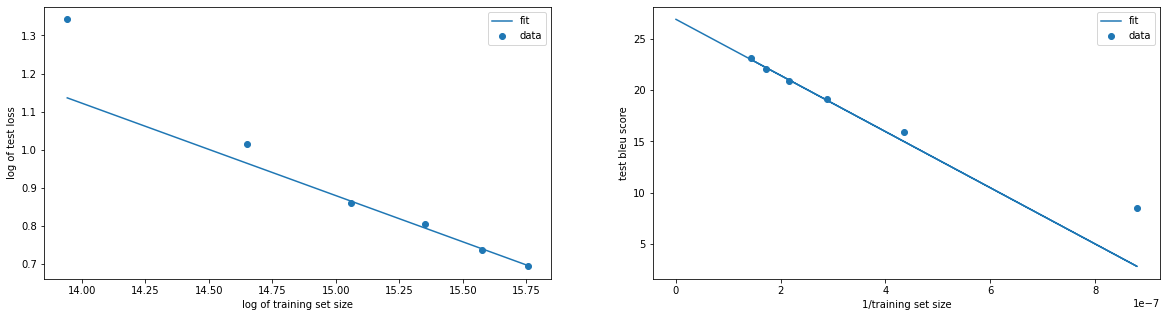

In [ ]:
def linear_fn(x, a, b):
    return a*x + b

fig, ax = plt.subplots(1, 2, figsize=(20,5))

logsize = np.log(sizes)
logloss = np.log(test_losses)
fit_params, _ = curve_fit(linear_fn, logsize[2:], logloss[2:])
print(fit_params)

loss_fitted_data = linear_fn(logsize, fit_params[0], fit_params[1])
ax[0].scatter(logsize, logloss, label='data')
ax[0].plot(logsize, loss_fitted_data, label='fit')
ax[0].set_xlabel('log of training set size')
ax[0].set_ylabel('log of test loss')
ax[0].legend()

oneoversizes = np.reciprocal(np.array(sizes, dtype=float))
fit_params, _ =curve_fit(linear_fn, oneoversizes[2:], test_bleus[2:])
print(fit_params)
bleu_fitted_data = linear_fn(np.insert(oneoversizes, 0, 0, 0), fit_params[0], fit_params[1])

ax[1].plot(np.insert(oneoversizes, 0, 0, 0), bleu_fitted_data, label='fit')
ax[1].scatter(np.reciprocal(np.array(sizes, dtype=float)), test_bleus,  label='data')
ax[1].set_xlabel('1/training set size')
ax[1].set_ylabel('test bleu score')
ax[1].legend()
plt.show()

Training set size in the above plots are defined as the number of tokens in the English sentences in the training set. The fits above are from the last four data points. From the first plot above, the test loss and the training set size kind of follow a power law. And from the second plot, the BLEU score seems to improve as a linear function of 1/train_set_size, and approaches 26.9 as the training set size goes to infinity. But of course, I only have six data points from the range of 50k training examples to 300k training examples, it is hard to say what would happen if I use a much larger training set, and the fits above are not perfect.